# GRASS GIS时间框架快速入门

GRASS GIS时间框架在用户级别实现了时间GIS功能，并提供了一个API以实现新的时空处理模块。

[temporal framework](http://grass.osgeo.org/grass70/manuals/temporalintro.html)引入时空数据集来表示时间序列的栅格，3D栅格或矢量地图。

它提供了如下的功能：

* 为地图分配时间戳并在时间数据库中注册地图
* 修改时间戳
* 创建，重命名和删除时空数据集
* 在时空数据集中注册和注销地图
* 使用SQL'WHERE'语句查询在时空数据集中注册的地图
* 分析时空数据集的时空拓扑
* 时空数据集采样
* 计算已注册地图之间的时空关系
* 模块之间共享的高级功能
* 上述大多数功能是专用地图图层和时空数据集类的成员功能。

以下三种相关的数据类型可被用于构建时空数据集：

* 时空栅格数据集（*strds*）用于管理栅格地图时间序列。处理*strds*的模块具有命名前缀*t.rast*
* 时空3D栅格数据集（*str3ds*）用于管理3D栅格地图时间序列。处理*str3ds*的模块具有命名前缀*t.rast3d 
* 时空矢量数据集（*stvds*）用于管理矢量地图时间序列。处理*tvds*的模块具有命名前缀*t.vect *

参考文献: Gebbert, S., Pebesma, E., 2014. TGRASS: *A temporal GIS for field based environmental modeling.* Environmental Modelling & Software 53, 1-12. https://doi.org/10.1016/j.envsoft.2013.11.001

In [1]:
import grass.temporal as tgis
import grass.script as gscript

## 创建时空数据集

首先，初始化一个时空数据集实例：

In [2]:
tgis.init()

接下来，创建一个空的时空栅格数据集，指定其名称，类型（此处为：strds），时间类型（绝对，相对），标题和描述。可以将时间数据集想象为所选数据的容器，该时间戳将它们排序，描述其时空关系并保存所有类型的元数据。 这些地图本身仍是标准的GRASS GIS地图。

In [3]:
dataset_name = 'temperature'
dataset = tgis.open_new_stds(name=dataset_name, type='strds', temporaltype='absolute',
                             title="Temperature in Raleigh", descr="Created for test purposes",
                             semantic='mean', overwrite=True)

检查数据集是否被创建成功：

In [4]:
# Print some info about the new dataset
dataset.print_shell_info()

id=temperature@FUTURES_triangle
name=temperature
mapset=FUTURES_triangle
creator=geo
temporal_type=absolute
creation_time='2020-05-12 17:49:13.338092'
modification_time='2020-05-12 17:49:13.338133'
semantic_type=mean
start_time='None'
end_time='None'
granularity='None'
map_time=None
north=None
south=None
east=None
west=None
top=None
bottom=None
aggregation_type=None
number_of_maps=None
nsres_min=None
nsres_max=None
ewres_min=None
ewres_max=None
min_min=None
min_max=None
max_min=None
max_max=None
raster_register=raster_map_register_56f94090b60e4efbaf8a3af080ae98e4


## 向数据集中导入栅格地图

使用最小值和最大值创建一组温度随机图

In [5]:
# monthly mean Raleigh temperature
# 月平均温度
nc_temp_data = {1:[30, 51], 2: [32, 54], 3: [40, 63], 4: [48, 72],
                5:[57, 80], 6: [66, 87], 7: [70, 90], 8: [69, 88],
                9:[62, 82], 10:[50, 73], 11:[41, 64], 12:[32, 54]}
# list of maps to add into temporal dataset
# 要添加到时间数据集中的地图列表
maps = []
gscript.run_command('g.region', raster='elevation')

for month, values in nc_temp_data.iteritems():
    map_name = "temp_{mon}".format(mon=month)
    # 随机生成栅格图
    gscript.run_command('r.random.surface', output=map_name, seed=values, high=values[1], overwrite=True)
    
    maps.append(map_name)
print maps

['temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temp_6', 'temp_7', 'temp_8', 'temp_9', 'temp_10', 'temp_11', 'temp_12']


现在，将创建的地图注册到时间数据集中：

In [6]:
tgis.register_maps_in_space_time_dataset(type='raster', name=dataset_name, maps=','.join(maps), start='2014-01-01',
                                         increment="1 month", interval=True, update_cmd_list=True)

接下来，更新时间数据集的信息并打印其元数据：

In [7]:
dataset.update_from_registered_maps()
dataset.print_shell_info()

id=temperature@FUTURES_triangle
name=temperature
mapset=FUTURES_triangle
creator=geo
temporal_type=absolute
creation_time='2020-05-12 17:49:13.338092'
modification_time='2020-05-12 17:54:06.591407'
semantic_type=mean
start_time='2014-01-01 00:00:00'
end_time='2015-01-01 00:00:00'
granularity='1 month'
map_time=interval
north=228500.0
south=215000.0
east=645000.0
west=630000.0
top=0.0
bottom=0.0
aggregation_type=None
number_of_maps=12
nsres_min=10.0
nsres_max=10.0
ewres_min=10.0
ewres_max=10.0
min_min=1.0
min_max=1.0
max_min=51.0
max_max=90.0
raster_register=raster_map_register_56f94090b60e4efbaf8a3af080ae98e4


## 查询现有的时间数据集

在本例中，将学习如何从时间数据集中提取点的值。

In [8]:
coors = (638000, 222800.0)

获取时间数据集对象

In [9]:
strds = tgis.open_old_stds(dataset_name, "strds")

现在可以获取所有已注册的地图：

In [11]:
rows = strds.get_registered_maps(columns="name,mapset,start_time,end_time",
                                 where=None, order="start_time")
rows

获取有关已注册地图的信息（名称，开始时间），并使用GRASS GIS命令`r.what`查询数据：

In [12]:
from collections import OrderedDict
infos = OrderedDict()
for row in rows:
    name = row["name"] + "@" + row["mapset"]
    values = gscript.read_command('r.what', map=name, coordinates=coors).strip().split('|')
    infos[name] = {'date': row["start_time"], 'value': values[3]}
print infos

OrderedDict([('temp_1@FUTURES_triangle', {'date': datetime.datetime(2014, 1, 1, 0, 0), 'value': '27'}), ('temp_2@FUTURES_triangle', {'date': datetime.datetime(2014, 2, 1, 0, 0), 'value': '21'}), ('temp_3@FUTURES_triangle', {'date': datetime.datetime(2014, 3, 1, 0, 0), 'value': '31'}), ('temp_4@FUTURES_triangle', {'date': datetime.datetime(2014, 4, 1, 0, 0), 'value': '34'}), ('temp_5@FUTURES_triangle', {'date': datetime.datetime(2014, 5, 1, 0, 0), 'value': '46'}), ('temp_6@FUTURES_triangle', {'date': datetime.datetime(2014, 6, 1, 0, 0), 'value': '65'}), ('temp_7@FUTURES_triangle', {'date': datetime.datetime(2014, 7, 1, 0, 0), 'value': '42'}), ('temp_8@FUTURES_triangle', {'date': datetime.datetime(2014, 8, 1, 0, 0), 'value': '30'}), ('temp_9@FUTURES_triangle', {'date': datetime.datetime(2014, 9, 1, 0, 0), 'value': '41'}), ('temp_10@FUTURES_triangle', {'date': datetime.datetime(2014, 10, 1, 0, 0), 'value': '42'}), ('temp_11@FUTURES_triangle', {'date': datetime.datetime(2014, 11, 1, 0, 0),

### 写入CSV文件

要在Python中写出CSV文件，应使用CSV模块。 因此，导入CSV和tempfile模块，然后在临时目录中创建一个新的CSV文件：

In [13]:
import csv
import tempfile
fil = tempfile.NamedTemporaryFile(delete=False)
fil.name = fil.name + '.csv'
print fil.name

/tmp/grass7-geo-112214/tmpOzNsDp.csv


现在，对于从时间数据集中读取的每条记录，该过程将各自的记录存储在CSV文件中：

In [14]:
with open(fil.name, 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=';',
                            quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Map_name', 'Date', 'Temp'])
    
    for mapp, vals in infos.iteritems():
        spamwriter.writerow([mapp, vals['date'].strftime('%Y-%m-%d'), vals['value']])
fil.close()

为了验证，我们可以简单地使用`cat` shell命令将CSV文件打印到终端：

In [15]:
!cat {fil.name}

### 使用 Matplotlib可视化数据

要使用`Matplotlib`可视化数据，必须先导入一些库：

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

创建x，y值的list

In [17]:
x = []
y = []
for mapp, vals in infos.iteritems():
    x.append(vals['date'])
    y.append(vals['value'])
print x
print y

[datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2014, 2, 1, 0, 0), datetime.datetime(2014, 3, 1, 0, 0), datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2014, 5, 1, 0, 0), datetime.datetime(2014, 6, 1, 0, 0), datetime.datetime(2014, 7, 1, 0, 0), datetime.datetime(2014, 8, 1, 0, 0), datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2014, 10, 1, 0, 0), datetime.datetime(2014, 11, 1, 0, 0), datetime.datetime(2014, 12, 1, 0, 0)]
['27', '21', '31', '34', '46', '65', '42', '30', '41', '42', '25', '21']


最后将温度变化可视化出来

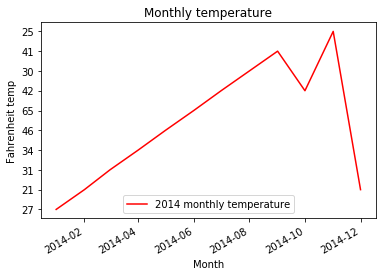

In [18]:
# create the plot
fig, ax = plt.subplots()
# create the plot line
ax.plot(x,y, label='2014 monthly temperature', color='red')
# set the format of X axis label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# set the title of graph
plt.title('Monthly temperature');
# add legend and set it lower-center position
ax.legend(loc='lower center')
# fix the position/rotation of X lavel
fig.autofmt_xdate()
# set the label for X and Y axis
ax.set_xlabel('Month')
ax.set_ylabel('Fahrenheit temp')
# show the graph
plt.show()

## 额外提示


### 将地图解除在时间数据集中注册


要从时间数据集中删除地图（不会真正删除它们，而只是从时间数据集中取消注册），首先应创建一个新的时间数据集对象。 然后，使用这个新的数据集对象，我们使用`unregister_map`函数删除选定的地图：

In [19]:
remove_map = tgis.RasterDataset('temp_12@{mapset}'.format(mapset=gscript.gisenv()['MAPSET']))
dataset.unregister_map(remove_map)
dataset.update_from_registered_maps()

### 删除一个时间数据集


从时间数据库中删除时空数据集（同样，所包含的地图保留在GRASS GIS中）可以使用`delete`函数直接从同一对象中完成：

In [20]:
dataset.delete()

''